# Project 3: Neural Net from Scratch

In this project, you will create a neural network by hand to perform binary
classification on a synthetic (made-up) dataset.  In this project, the data
is a simple 2-dimensional dataset so it can be easily plotted and visualized.

The goal of this project is not only to create the neural net from scratch, but
also to get practice training neural nets of various depths and seeing how
they work.


## Introduction

Let's examine our data set a little.

Red points: 190
Blue points: 210


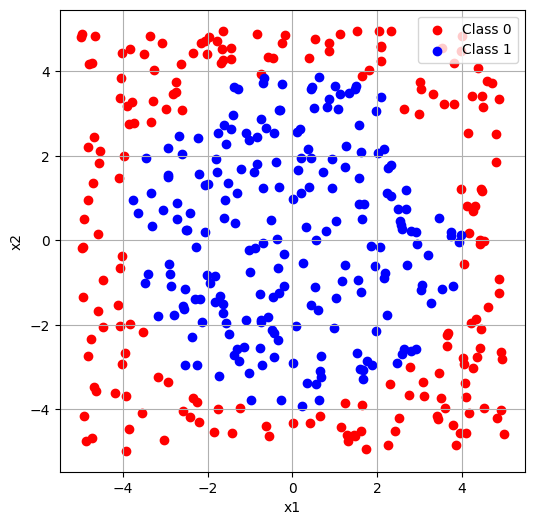

In [85]:
# Read data and plot

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

alldata = np.loadtxt("output.csv", delimiter=",")
X = alldata[:, :2]
Y = alldata[:, 2:]

# Number of data points
m = 400

print("Red points:", np.sum(Y[:, 0] == 0))
print("Blue points:", np.sum(Y[:, 0] == 1))

# Plot X, colored by Y
plt.figure(figsize=(6, 6))
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], color='red', label='Class 0')
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], color='blue', label='Class 1')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()

In [86]:
## Create testing and training sets.

# In the real world, we would shuffle the data to make a random training/testing split,
# but here, since we have 200 examples, we're going to use the first half of each
# language for training and the last half for testing.

# So create a training set of rows 0-199,
# and a testing set of rows 200-399.
                      
X_train = X[:200, :]
X_test = X[200:, :]
Y_train = Y[:200, :]
Y_test = Y[200:, :]

# Sanity checks.
print(X_train.shape)  # should be (200, 2)
print(X_test.shape) # should be (200, 2)
print(Y_train.shape) # should be (200, 1)
print(Y_test.shape) # should be (200, 1)


(200, 2)
(200, 2)
(200, 1)
(200, 1)


In [87]:
# Neural Network class.  The bulk of this project is writing a general-purpose
# python class that will allow a neural network of any number of layers and
# sizes of each layer.  You should fill in this class according to the backprop
# handout provided.

# The __init__ function and check_dimensions are already completed.
# The others require you to fill in some code.

import numpy as np
import scipy
sigmoid = scipy.special.expit
relu = lambda x: np.maximum(0, x)
relu_deriv = np.vectorize(lambda x: 1 if x>0 else 0)
from scipy.special import xlogy

class NeuralNet:
    
    def __init__(self, sizes: list[int]):
        """
        Initialize all of the variables we need to keep track of.
        W, b, Z, A, delta, deriv_W, and deriv_b are lists of matrices.
        """
        self.L = len(sizes)-1
        self.sizes = sizes     # of neurons in each layer #//
        self.W = [None] * (self.L+1)        # W[0] through W[L], but index 0 ignored
        self.b = [None] * (self.L+1)        # b[0] through b[L], but index 0 ignored
        self.Z = [None] * (self.L+1)        # Z[0] through b[L], but index 0 ignored
        self.A = [None] * (self.L+1)        # A[0] through b[L], A[0] represents the input matrix X
        self.delta = [None] * (self.L+1)    # index 0 ignored
        self.deriv_W = [None] * (self.L+1)  # index 0 ignored
        self.deriv_b = [None] * (self.L+1)  # index 0 ignored

    def check_dimensions(self):
        """
        Print out dimensions of all the matrices - useful for debugging.
        """
        for ell in range(1, self.L+1): # ell = L in the notes 
            if self.W[ell] is not None: print(f"dim of W{ell} is", self.W[ell].shape)
            if self.b[ell] is not None: print(f"dim of b{ell} is", self.b[ell].shape) 
        for ell in range(1, self.L+1):
            if self.Z[ell] is not None: print(f"dim of Z{ell} is", self.Z[ell].shape) 
            if self.A[ell] is not None: print(f"dim of A{ell} is", self.A[ell].shape) 
        for ell in range(1, self.L+1):
            if self.delta[ell] is not None: print(f"dim of delta{ell} is", self.delta[ell].shape)
            if self.deriv_W[ell] is not None: print(f"dim of deriv_W{ell} is", self.deriv_W[ell].shape) 
            if self.deriv_b[ell] is not None: print(f"dim of deriv_b{ell} is", self.deriv_b[ell].shape) 

    def init_weights_randomly(self):
        """
        Set initial weights of W/b matrices randomly.
        """
        np.random.seed(0)  # for reproducability
        for ell in range(1, self.L+1):
            W_rows = self.sizes[ell - 1]
            W_cols = self.sizes[ell]
            b_length = self.sizes[ell]
            self.W[ell] = np.random.normal(0, 1, (W_rows, W_cols))
            self.b[ell] = np.random.normal(0, 1, (1, b_length))

    def forward_prop(self, X):
        """
        X is a matrix of features, m rows by n cols.
        returns: nothing
        
        This function should calculate and store all of the A and Z matrices appropriately.
        """
        self.A[0] = X # layer 0 the first activation layer

        for ell in range(1, self.L+1):
            self.Z[ell] = self.A[ell - 1] @ self.W[ell] + self.b[ell]
            if ell == self.L:
                self.A[ell] = sigmoid(self.Z[ell]) # Sigmoid function for the last/output layer
            else: 
                self.A[ell] = relu(self.Z[ell]) # ReLU for all other layers 
            


    def backward_prop(self, X, Y):
        """
        X is a matrix of features, m rows by n cols.
        Y is a matrix of correct outputs, m rows by n_L cols.
           Because this is binary classification, Y is (m by 1), and each output is 0 or 1.
        returns: nothing
           
        This function should calculate and store all of the delta, deriv_W, and deriv_B matrices appropriately.
        """
        m = X.shape[0]
        
        # goes backwards from the output/last layer to the first hidden layer stops at 1
        for ell in range(self.L, 0, -1):
            if ell == self.L:
                 self.delta[self.L] = self.A[self.L] - Y  # calcuates output layer (delta)
            else:
                self.delta[ell] = (self.delta[ell + 1] @ self.W[ell + 1].T) * relu_deriv(self.Z[ell])
                
            # calcuates the derivatives/gradients of weights/biases for each layer 
            self.deriv_W[ell] = self.A[ell - 1].T @ self.delta[ell]
            self.deriv_W[ell] = (self.deriv_W[ell]) / m
            self.deriv_b[ell] =  (np.sum(self.delta[ell], axis = 0))/m
           
            
            
        

    def predict(self, x):
        """
        x is a vector of one input (one row from the X matrix).
        returns: probability of x being in the "1" class (float between 0 and 1).

        This function does the same thing as forward_prop, but for only one row of input,
        and returns the result as a single float.
        """
        
        for ell in range(1, self.L+1):
            z = x @ self.W[ell] + self.b[ell]
            if ell == self.L:
                x = sigmoid(z)
            else: 
                x = relu(z)
            
        return x[0,0]
    

    def predict_01(self, x):
        """
        x is a vector of one input (one row from the X matrix).
        returns: 0 or 1

        This function does the same thing as predict, but rounds to 0 or 1.
        """
 
        for ell in range(1, self.L+1):
            z = x @ self.W[ell] + self.b[ell]
            if ell == self.L:
                x = sigmoid(z)
            else: 
                x = relu(z)
                
        if x[0,0] >= .5:
            return 1
        
        return 0

    def compute_cost(self, X, Y):
        """
        X is a matrix of features, m rows by n cols.
        Y is a matrix of correct outputs, m rows by n_L cols.
           Because this is binary classification, Y is (m by 1), and each output is 0 or 1.

        Return the total cost of putting all of the rows of X through the neural network, according
        to the cross-entropy loss function.  You can do this by calling self.predict on each row of X,
        or you can call self.forward_prop on X all at once and iterate over that.
        """
        m = X.shape[0]
        
        self.forward_prop(X)
        y_hat = self.A[self.L]
        cost = -xlogy(Y, y_hat) - xlogy(1 - Y, 1 - y_hat)
        
        return (np.sum(cost))/m



In [88]:
# Create a single-layer neural network, 2 features going to 1 output
nn1 = NeuralNet([2, 1])
nn1.init_weights_randomly()

In [89]:
# Sanity checks for forward_prop and predict

nn1.check_dimensions()
nn1.init_weights_randomly()
nn1.forward_prop(X_train[0:3])  # put first 3 rows of X through the NN
print(nn1.Z[1])
print()
print(nn1.A[1])
print()
print(nn1.predict(X_train[0]))  # put first row through by itself, should match 


dim of W1 is (2, 1)
dim of b1 is (1, 1)
[[ 3.58877378]
 [-3.63441269]
 [ 4.54258914]]

[[0.97311081]
 [0.02572043]
 [0.98946633]]

0.9731108143652976


In [90]:
# Sanity check for backprop.

nn1.check_dimensions()
nn1.init_weights_randomly()
nn1.backward_prop(X_train[0:3], Y_train[0:3])   # put first 3 rows of X through backprop

print(nn1.delta[1])
print()
print(nn1.deriv_W[1])
print()
print(nn1.deriv_b[1])
print()

dim of W1 is (2, 1)
dim of b1 is (1, 1)
dim of Z1 is (3, 1)
dim of A1 is (3, 1)
[[-0.02688919]
 [-0.97427957]
 [-0.01053367]]

[[ 0.86176262]
 [-0.14478211]]

[-0.33723414]



In [91]:
# Sanity check for compute cost

nn1.check_dimensions()
nn1.init_weights_randomly()
nn1.compute_cost(X_train, Y_train)

dim of W1 is (2, 1)
dim of b1 is (1, 1)
dim of Z1 is (3, 1)
dim of A1 is (3, 1)
dim of delta1 is (3, 1)
dim of deriv_W1 is (2, 1)
dim of deriv_b1 is (1,)


np.float64(2.1593666474014013)

In [92]:
# Write gradient descent:

ALPHA = .1

J_sequence = []

nn1.init_weights_randomly()

nn1.forward_prop(X_train) 
nn1.backward_prop(X_train, Y_train)
for ctr in range(100000): 
    nn1.forward_prop(X_train) 
    nn1.backward_prop(X_train, Y_train)

    # Loops through each layer updating the weights and biases
    for ell in range(1, nn1.L + 1):
        nn1.W[ell] -= ALPHA * nn1.deriv_W[ell]
        nn1.b[ell] -= ALPHA * nn1.deriv_b[ell]
    
    cost = nn1.compute_cost(X_train, Y_train)
    J_sequence.append(cost)

print("Final cost:", J_sequence[-1])
print("Final parameters:")
print(nn1.W)
print(nn1.b)

Final cost: 0.6917094226392375
Final parameters:
[None, array([[-0.0011571 ],
       [-0.01374817]])]
[None, array([[0.10207588]])]


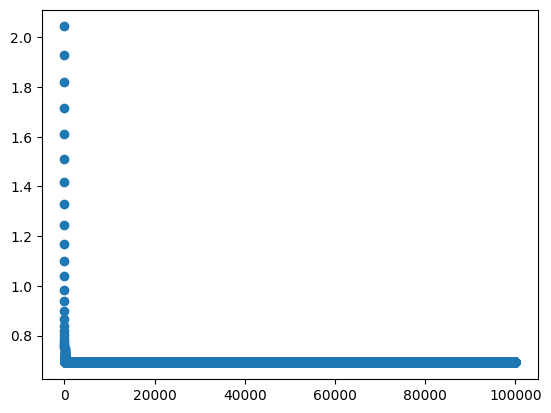

In [93]:
# Let's plot the cost as a function of number of iterations of the
# gradient descent algorithm.

plt.scatter(range(0, len(J_sequence)), J_sequence)
plt.show()

In [94]:
# Test/train accuracy - write this function

def compute_accuracy(X, Y):
    """
    Returns fraction of the examples in X that were classified correctly.
    You will want to call nn1.predict.
    """
    num_right = 0 
    m = X.shape[0]

    for i in range(m):
        if nn1.predict_01(X[i]) == Y[i,0]:
            num_right += 1
    return num_right/m

# Testing and training accuracy for a 1-layer network should be close to 50%, but
# mathematically for this neural net can't get much higher.

print(compute_accuracy(X_train, Y_train))
print(compute_accuracy(X_test, Y_test))

0.525
0.525


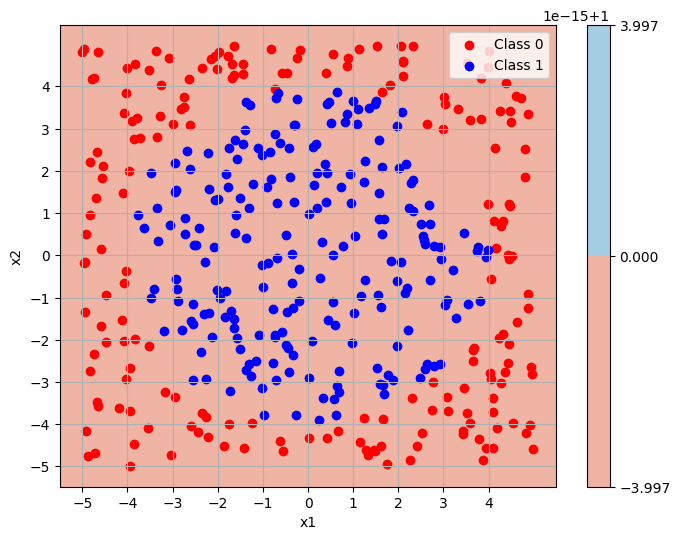

In [95]:
# Plot the predictions on a graph.

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Create a grid of points
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]  # shape: (resolution^2, 2)

# Predict on the grid
probs = np.array([nn1.predict_01(row) for row in grid])

if probs.ndim > 1 and probs.shape[1] == 1:
    probs = probs.ravel()
Z = probs.reshape(xx.shape)

# Plot contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, Z, levels=50, cmap="RdBu", alpha=0.6)
plt.colorbar(contour)

# Plot original data points
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], color='red', label='Class 0')
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], color='blue', label='Class 1')
plt.xticks(np.arange(-5, 5, 1))
plt.yticks(np.arange(-5, 5, 1))
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


# 2 layer neural net

Now we will repeat this for a 2-layer network.  You get to pick the number
of neurons in the hidden layer.

In [106]:
# Create a single-layer neural network, 
# 2 features going to (variable) hidden layer, going to 1 output
nn2 = NeuralNet([2, 4, 1])   # good place to start/ When I used this array I could get the cost way less than 0.07 
# nn2 = NeuralNet([2, 3, 1]) # The .pdf to check uses this array/ When I used this this array I could not get the cost less than 0.07
nn2.init_weights_randomly()

In [107]:
nn2.check_dimensions()
nn2.init_weights_randomly()
nn2.forward_prop(X_train[0:3])  # put first 3 rows of X through the NN
print(nn2.Z)
print()
print(nn2.A)
print()
print(nn2.predict(X_train[0]))  # put first row through by itself, should match 


dim of W1 is (2, 4)
dim of b1 is (1, 4)
dim of W2 is (4, 1)
dim of b2 is (1, 1)
[None, array([[-0.63138104,  3.28679961,  0.03509171,  6.18062801],
       [-3.96337281, -1.18391706, -2.04183157, -4.74437281],
       [ 2.33228915,  2.04028758,  1.56150905,  6.48872401]]), array([[3.97189328],
       [1.49407907],
       [6.3755082 ]])]

[array([[ 1.96469, -2.13861],
       [-2.73149,  0.51315],
       [ 2.19469, -0.76894]]), array([[0.        , 3.28679961, 0.03509171, 6.18062801],
       [0.        , 0.        , 0.        , 0.        ],
       [2.33228915, 2.04028758, 1.56150905, 6.48872401]]), array([[0.98151056],
       [0.81668973],
       [0.99830014]])]

0.9815105648760776


In [108]:
# Sanity check for backprop.

nn2.check_dimensions()
nn2.init_weights_randomly()
nn2.backward_prop(X_train[0:3], Y_train[0:3])   # put first 3 rows of X through backprop

print(nn2.delta)
print()
print(nn2.deriv_W)
print()
print(nn2.deriv_b)
print()

dim of W1 is (2, 4)
dim of b1 is (1, 4)
dim of W2 is (4, 1)
dim of b2 is (1, 1)
dim of Z1 is (3, 4)
dim of A1 is (3, 4)
dim of Z2 is (3, 1)
dim of A2 is (3, 1)
[None, array([[-0.        , -0.0022497 , -0.00820678, -0.00616945],
       [-0.        , -0.        , -0.        , -0.        ],
       [-0.00129366, -0.00020683, -0.00075451, -0.0005672 ]]), array([[-0.01848944],
       [-0.18331027],
       [-0.00169986]])]

[None, array([[-0.00094639, -0.00162463, -0.00592656, -0.00445529],
       [ 0.00033158,  0.00165676,  0.00604376,  0.0045434 ]]), array([[-0.00132152],
       [-0.02141309],
       [-0.00110106],
       [-0.04176875]])]

[None, array([-0.00043122, -0.00081884, -0.0029871 , -0.00224555]), array([-0.06783319])]



In [109]:
# Sanity check for compute cost

nn2.check_dimensions()
nn2.init_weights_randomly()
nn2.compute_cost(X_train, Y_train)

dim of W1 is (2, 4)
dim of b1 is (1, 4)
dim of W2 is (4, 1)
dim of b2 is (1, 1)
dim of Z1 is (3, 4)
dim of A1 is (3, 4)
dim of Z2 is (3, 1)
dim of A2 is (3, 1)
dim of delta1 is (3, 4)
dim of deriv_W1 is (2, 4)
dim of deriv_b1 is (4,)
dim of delta2 is (3, 1)
dim of deriv_W2 is (4, 1)
dim of deriv_b2 is (1,)


np.float64(3.1901239915099744)

In [110]:
# Write gradient descent:

ALPHA = .3

J_sequence = []

nn2.init_weights_randomly()

# write your gradient descent loop - don't forget to use "nn2" not "nn1"!

nn2.forward_prop(X_train) 
nn2.backward_prop(X_train, Y_train)
for ctr in range(100000): 
    nn2.forward_prop(X_train) 
    nn2.backward_prop(X_train, Y_train)

    # Loops through each layer updating the weights and biases
    for ell in range(1, nn2.L + 1):
        nn2.W[ell] -= ALPHA * nn2.deriv_W[ell]
        nn2.b[ell] -= ALPHA * nn2.deriv_b[ell]
    
    cost = nn2.compute_cost(X_train, Y_train)
    J_sequence.append(cost)
    
print("Final cost:", J_sequence[-1])
print("Final parameters:")
print(nn2.W)
print(nn2.b)

Final cost: 0.000362792699150816
Final parameters:
[None, array([[ 2.50938374, -5.75141092,  1.39894066,  6.40761223],
       [ 7.99557371, -1.44735829,  0.84196401, -4.36286742]]), array([[-8.0307106 ],
       [-5.75534836],
       [13.39419097],
       [-7.51822262]])]
[None, array([[ 0.11543921, -0.99050478, 14.5978547 ,  0.14169544]]), array([[7.18348472]])]


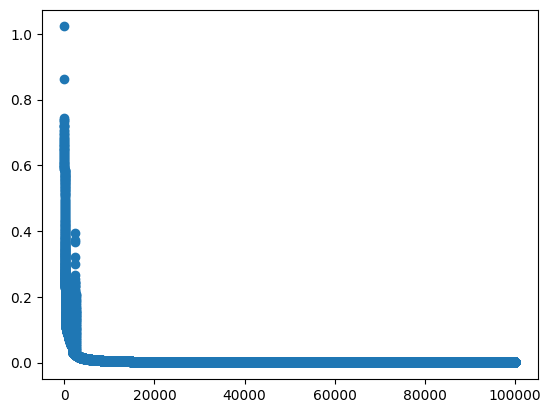

In [111]:
# Let's plot the cost as a function of number of iterations of the
# gradient descent algorithm.

plt.scatter(range(0, len(J_sequence)), J_sequence)
plt.show()

In [112]:
# Test/train accuracy - write this function

def compute_accuracy(X, Y):
    """
    Returns fraction of the examples in X that were classified correctly.
    You will want to call nn2.predict.
    """
    num_right = 0 
    m = X.shape[0]

    for i in range(m):
        if nn2.predict_01(X[i]) == Y[i,0]:
            num_right += 1
    return num_right/m

# Testing and training accuracy for a 2-layer network can get easily over 90%.

print(compute_accuracy(X_train, Y_train))
print(compute_accuracy(X_test, Y_test))

1.0
0.965


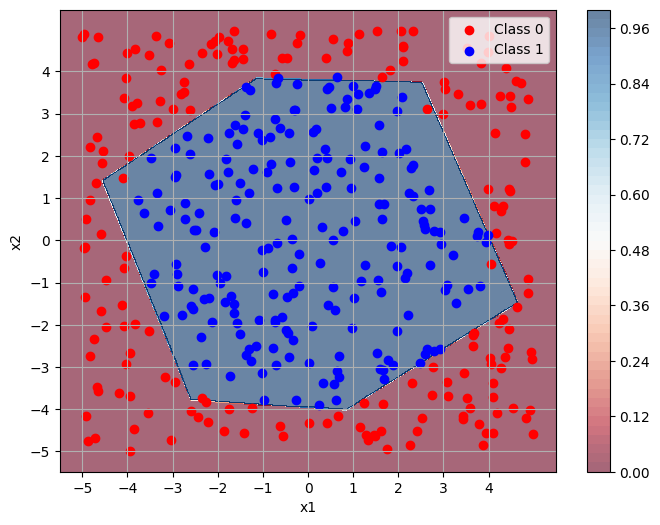

In [113]:
# Plot the predictions on a graph.

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Create a grid of points
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]  # shape: (resolution^2, 2)

# Predict on the grid
probs = np.array([nn2.predict_01(row) for row in grid])

if probs.ndim > 1 and probs.shape[1] == 1:
    probs = probs.ravel()
Z = probs.reshape(xx.shape)

# Plot contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, Z, levels=50, cmap="RdBu", alpha=0.6)
plt.colorbar(contour)

# Plot original data points
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], color='red', label='Class 0')
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], color='blue', label='Class 1')
plt.xticks(np.arange(-5, 5, 1))
plt.yticks(np.arange(-5, 5, 1))
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()


In [114]:
# Repeat the steps above with a 3-layer network, mostly just to show
# your code works with 3 layers.  Keep the number of neurons at each
# layer pretty small, try something like (2, 3, 3, 1).

# Copy all the code from the cells above to create your 3-layer network.
# Your final output must include gradient descent, the learning curve graph,
# and the plot showing the "shape" of the predictions.

# In the code that generates the shape of the predictions, you just need to find the one line
# referencing nn1/nn2 and change it to your new variable (presumably nn3).

In [115]:
# Create a single-layer neural network, 
# 2 features going to (variable) hidden layer, going to 1 output
nn3 = NeuralNet([2, 3, 3, 1])   # good place to start
nn3.init_weights_randomly()

In [116]:
nn3.check_dimensions()
nn3.init_weights_randomly()
nn3.forward_prop(X_train[0:3])  # put first 3 rows of X through the NN
print(nn3.Z)
print()
print(nn3.A)
print()
print(nn3.predict(X_train[0]))  # put first row through by itself, should match 

dim of W1 is (2, 3)
dim of b1 is (1, 3)
dim of W2 is (3, 3)
dim of b2 is (1, 3)
dim of W3 is (3, 1)
dim of b3 is (1, 1)
[None, array([[-0.37649218, -3.35915054,  3.90971412],
       [-2.71848858, -0.28604524, -3.27812201],
       [ 3.09852404, -0.70917623,  2.79627567]]), array([[ 1.61763893,  4.98732632, -3.35509998],
       [ 0.3130677 , -0.85409574, -2.55298982],
       [ 2.51836243,  3.77008369,  1.37943255]]), array([[7.63829891],
       [2.4743815 ],
       [6.15103337]])]

[array([[ 1.96469, -2.13861],
       [-2.73149,  0.51315],
       [ 2.19469, -0.76894]]), array([[0.        , 0.        , 3.90971412],
       [0.        , 0.        , 0.        ],
       [3.09852404, 0.        , 2.79627567]]), array([[1.61763893, 4.98732632, 0.        ],
       [0.3130677 , 0.        , 0.        ],
       [2.51836243, 3.77008369, 1.37943255]]), array([[0.99951858],
       [0.92232624],
       [0.99787325]])]

0.9995185847938622


In [117]:
# Sanity check for backprop.

nn3.check_dimensions()
nn3.init_weights_randomly()
nn3.backward_prop(X_train[0:3], Y_train[0:3])   # put first 3 rows of X through backprop

print(nn3.delta)
print()
print(nn3.deriv_W)
print()
print(nn3.deriv_b)
print()

dim of W1 is (2, 3)
dim of b1 is (1, 3)
dim of W2 is (3, 3)
dim of b2 is (1, 3)
dim of W3 is (3, 1)
dim of b3 is (1, 1)
dim of Z1 is (3, 3)
dim of A1 is (3, 3)
dim of Z2 is (3, 3)
dim of A2 is (3, 3)
dim of Z3 is (3, 1)
dim of A3 is (3, 1)
[None, array([[-0.        , -0.        , -0.00072676],
       [-0.        , -0.        , -0.        ],
       [ 0.00145984, -0.        , -0.00353442]]), array([[-0.00031466, -0.00041615,  0.        ],
       [-0.05076901, -0.        ,  0.        ],
       [-0.00139008, -0.00183844,  0.0015784 ]]), array([[-0.00048142],
       [-0.07767376],
       [-0.00212675]])]

[None, array([[ 0.00106797,  0.        , -0.00306161],
       [-0.00037418,  0.        ,  0.00142401]]), array([[-0.00143573, -0.00189881,  0.00163023],
       [ 0.        ,  0.        ,  0.        ],
       [-0.00170576, -0.00225594,  0.00147121]]), array([[-0.01015061],
       [-0.00347299],
       [-0.0009779 ]])]

[None, array([ 0.00048661,  0.        , -0.00142039]), array([-0.0174912

In [118]:
# Sanity check for compute cost

nn3.check_dimensions()
nn3.init_weights_randomly()
nn3.compute_cost(X_train, Y_train)

dim of W1 is (2, 3)
dim of b1 is (1, 3)
dim of W2 is (3, 3)
dim of b2 is (1, 3)
dim of W3 is (3, 1)
dim of b3 is (1, 1)
dim of Z1 is (3, 3)
dim of A1 is (3, 3)
dim of Z2 is (3, 3)
dim of A2 is (3, 3)
dim of Z3 is (3, 1)
dim of A3 is (3, 1)
dim of delta1 is (3, 3)
dim of deriv_W1 is (2, 3)
dim of deriv_b1 is (3,)
dim of delta2 is (3, 3)
dim of deriv_W2 is (3, 3)
dim of deriv_b2 is (3,)
dim of delta3 is (3, 1)
dim of deriv_W3 is (3, 1)
dim of deriv_b3 is (1,)


np.float64(2.320207061017352)

In [119]:
# Write gradient descent:

ALPHA = .3

J_sequence = []

nn3.init_weights_randomly()

# write your gradient descent loop - don't forget to use "nn3" not "nn1"!

nn3.forward_prop(X_train) 
nn3.backward_prop(X_train, Y_train)
for ctr in range(100000): 
    nn3.forward_prop(X_train) 
    nn3.backward_prop(X_train, Y_train)

    # Loops through each layer updating the weights and biases
    for ell in range(1, nn3.L + 1):
        nn3.W[ell] -= ALPHA * nn3.deriv_W[ell]
        nn3.b[ell] -= ALPHA * nn3.deriv_b[ell]
    
    cost = nn3.compute_cost(X_train, Y_train)
    J_sequence.append(cost)
    
print("Final cost:", J_sequence[-1])
print("Final parameters:")
print(nn3.W)
print(nn3.b)

Final cost: 0.07525314352817794
Final parameters:
[None, array([[ 2.22581733, -3.03681414,  0.64483529],
       [ 1.96795865,  0.62450031, -3.12613337]]), array([[-8.76009308,  1.90238598,  1.45793795],
       [ 0.36252064,  2.38934389,  1.83206065],
       [-0.18122725,  2.08119154,  1.59422669]]), array([[ 1.11336968],
       [-1.32268678],
       [-1.01389797]])]
[None, array([[ 1.15972605, -0.94193011, -1.54604521]]), array([[  1.85230249, -18.20836553, -13.95754231]]), array([[8.20666733]])]


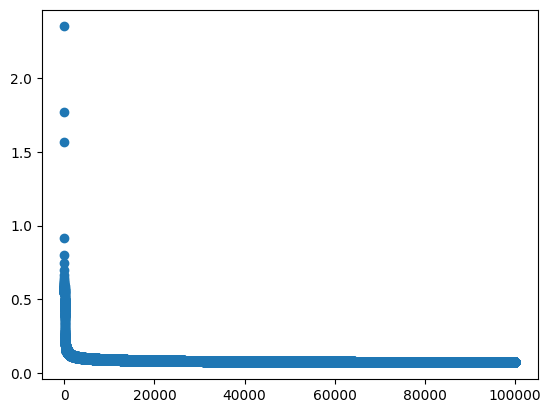

In [120]:
# Let's plot the cost as a function of number of iterations of the
# gradient descent algorithm.

plt.scatter(range(0, len(J_sequence)), J_sequence)
plt.show()

In [121]:
# Test/train accuracy - write this function
def compute_accuracy(X, Y):
    """
    Returns fraction of the examples in X that were classified correctly.
    You will want to call nn3.predict.
    """
    num_right = 0 
    m = X.shape[0]

    for i in range(m):
        if nn3.predict_01(X[i]) == Y[i,0]:
            num_right += 1
    return num_right/m

# Testing and training accuracy for a 2-layer network can get easily over 90%.

print(compute_accuracy(X_train, Y_train))
print(compute_accuracy(X_test, Y_test))

0.965
0.955


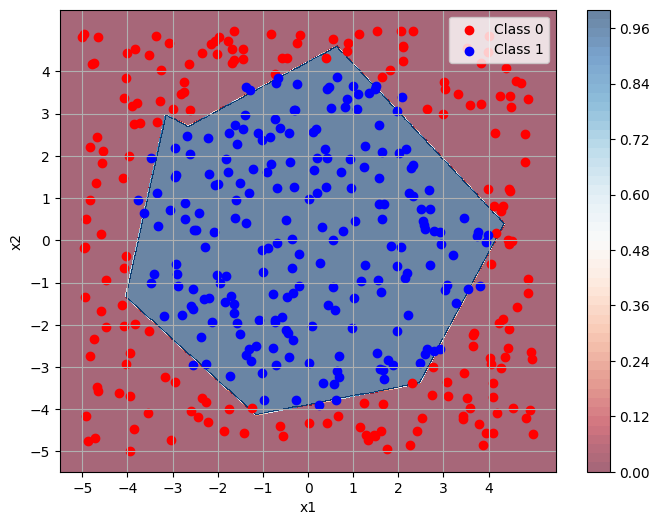

In [122]:
# Plot the predictions on a graph.

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

# Create a grid of points
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 500),
    np.linspace(y_min, y_max, 500)
)
grid = np.c_[xx.ravel(), yy.ravel()]  # shape: (resolution^2, 2)

# Predict on the grid
probs = np.array([nn3.predict_01(row) for row in grid])

if probs.ndim > 1 and probs.shape[1] == 1:
    probs = probs.ravel()
Z = probs.reshape(xx.shape)

# Plot contour
plt.figure(figsize=(8, 6))
contour = plt.contourf(xx, yy, Z, levels=50, cmap="RdBu", alpha=0.6)
plt.colorbar(contour)

# Plot original data points
plt.scatter(X[Y[:, 0] == 0, 0], X[Y[:, 0] == 0, 1], color='red', label='Class 0')
plt.scatter(X[Y[:, 0] == 1, 0], X[Y[:, 0] == 1, 1], color='blue', label='Class 1')
plt.xticks(np.arange(-5, 5, 1))
plt.yticks(np.arange(-5, 5, 1))
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.grid(True)
plt.show()